<a href="https://colab.research.google.com/github/alaeddinehamroun/Recurrent-Neural-Networks/blob/main/Character_Level_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired from [The Sequence Models course on Coursera by Andrew Ng](https://www.coursera.org/learn/nlp-sequence-models?specialization=deep-learning)

Given a [dataset](https://tjauahja.labs.coursera.org/files/W1A2/dinos.txt) of dinosaur names, the algorithm will learn the different name patterns, and randomly generate new names.

# Packages

In [13]:
import numpy as np
import random
import copy
import pprint

# Utils functions

In [2]:
def softmax(x):
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis = 0)

In [21]:
def smooth(loss, cur_loss):
    return loss * 0.999 + cur_loss * 0.001

In [22]:
def get_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    return txt

In [20]:
def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length

In [19]:
def initialize_parameters(n_a, n_x, n_y):
    """
    Initialize parameters with small random values
    
    Returns:
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    """
    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

In [3]:
def rnn_step_forward(parameters, a_prev, x):
    
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    a_next = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b) # hidden state
    p_t = softmax(np.dot(Wya, a_next) + by) # unnormalized log probabilities for next chars # probabilities for next chars 
    
    return a_next, p_t

In [4]:
def rnn_step_backward(dy, gradients, parameters, x, a, a_prev):
    
    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next'] # backprop into h
    daraw = (1 - a * a) * da # backprop through tanh nonlinearity
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    return gradients

In [5]:
def rnn_forward(X, Y, a0, parameters, vocab_size = 27):
    
    # Initialize x, a and y_hat as empty dictionaries
    x, a, y_hat = {}, {}, {}
    
    a[-1] = np.copy(a0)
    
    # initialize your loss to 0
    loss = 0
    
    for t in range(len(X)):
        
        # Set x[t] to be the one-hot vector representation of the t'th character in X.
        # if X[t] == None, we just have x[t]=0. This is used to set the input for the first timestep to the zero vector. 
        x[t] = np.zeros((vocab_size,1)) 
        if (X[t] != None):
            x[t][X[t]] = 1
        
        # Run one step forward of the RNN
        a[t], y_hat[t] = rnn_step_forward(parameters, a[t-1], x[t])
        
        # Update the loss by substracting the cross-entropy term of this time-step from it.
        loss -= np.log(y_hat[t][Y[t],0])
        
    cache = (y_hat, a, x)
        
    return loss, cache

In [7]:
def rnn_backward(X, Y, parameters, cache):
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (y_hat, a, x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    
    # each one should be initialized to zeros of the same dimension as its corresponding parameter
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])
    
    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -= 1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1])
    
    return gradients, a

In [17]:
def update_parameters(parameters, gradients, lr):

  parameters['Wax'] += -lr * gradients['dWax']
  parameters['Waa'] += -lr * gradients['dWaa']
  parameters['Wya'] += -lr * gradients['dWya']
  parameters['b']  += -lr * gradients['db']
  parameters['by']  += -lr * gradients['dby']
  return parameters

# Problem Statement

## Dataset and Preprocessing

In [9]:
# read the dataset of dinosaur names, create a list  of unique characters, and compute the dataset and vocabulary size.
data = open('dinos.txt', 'r').read()
data = data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' %(data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.


The characters are a-z (26 characters) plus the "\n" (or newline character). Here, the "\n" indicates the end of the dinosaur name rather than the end of a sentence.

In [10]:
chars = sorted(chars)
print(chars)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [14]:
# create a python dictionary (a hash table) to map each character to an index from 0-26.
char_to_ix = { ch: i for i, ch in enumerate(chars) }
# create a second python dictionary that maps each index back to the corresponding character.
ix_to_char = { i: ch for i, ch in enumerate(chars) }
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ix_to_char)

{   0: '\n',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'}


## Overview of the model:
*   Initialize parameters
*   Run the optimization loop
  *   Forward propagation to compute the loss function
  *   Backward propagation to compute the gradients with respect to the loss function
  *   Clip the gradients to avoid exploding gradients
  *   Using the gradients, update the parameters with the gradient descent update rule.
*   Return the learned parameters
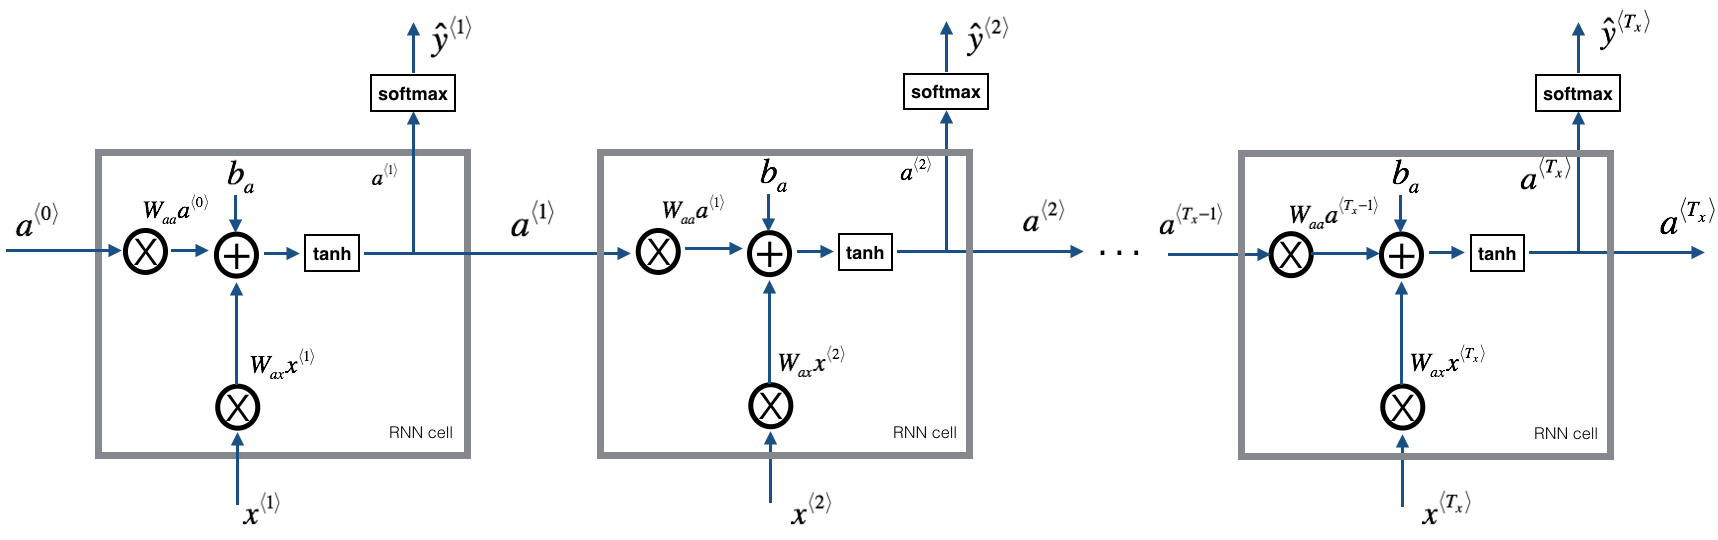

<caption><center><font color='purple'><b>Figure 1</b>: Recurrent Neural Network </center></caption>

* At each time-step, the RNN tries to predict what the next character is, given the previous characters. 
* $\mathbf{X} = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters from the training set.
* $\mathbf{Y} = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is the same list of characters but shifted one character forward. 
* At every time-step $t$, $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$.  The prediction at time $t$ is the same as the input at time $t + 1$.

# Building Blocks of the Model

## Clipping the Gradients in the Optimization Loop
When gradients are very large, they're called "exploding gradients".
Exploding gradients make the training process more difficult, because the updates may be so large that they "overshoot" the optimal values during back propagation.

Gradient clipping will help avoid exploding gradients.

There are different ways to clip gradients. We will use a simple element-wise clipping procedure, in which every element of the gradient vector is clipped to fall between some range [-N, N].

For example, if the N=10
*   The range is [-10, 10]
*   If any component of the gradient vector is greater than 10, it is set to 10.
*   If any component of the gradient vector is less than -10, it is set to -10.
*   If any components are between -10 and 10, they keep their original values.


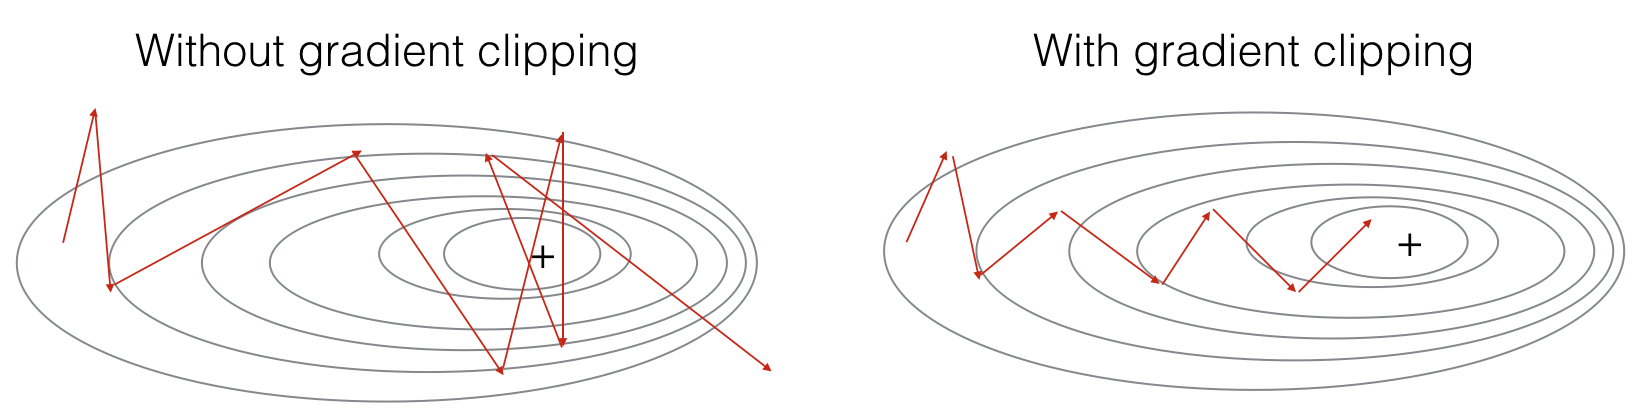
<caption><center><font color='purple'><b>Figure 2</b>: Visualization of gradient descent with and without gradient clipping, in a case where the network is running into "exploding gradient" problems. </center></caption>

In [15]:
def clip(gradients, maxValue):
  """
  Clips the gradients' values between minimum and maximum.
  Arguments:
  gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
  maxValue -- everything above this number is set to this number, and everything less than -maxValue is to -maxValue

  Returns:
  gradients -- a dictionary with the clipped gradients.
  """
  gradients = copy.deepcopy(gradients)

  dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']

  # clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]
  for gradient in [dWax, dWaa, dWya, db, dby]:
    np.clip(gradient, -maxValue, maxValue, out=gradient)
  
  gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}
    
  return gradients

## Sampling

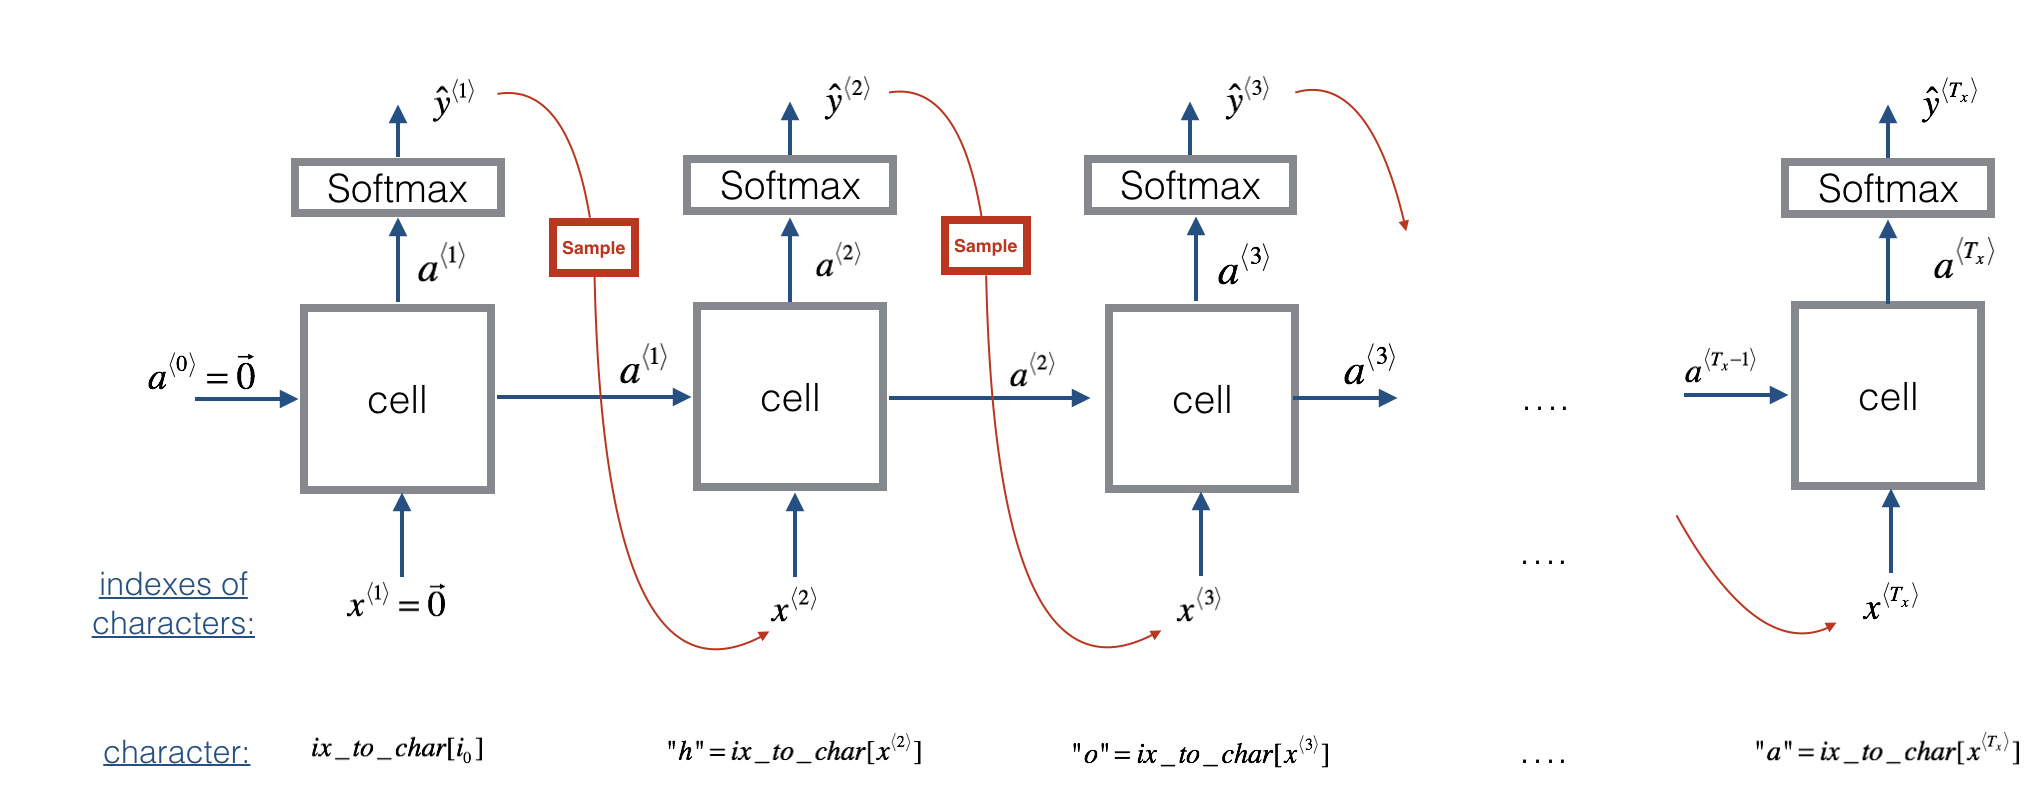
<caption><center><font color='purple'><b>Figure 3</b>: In this picture, you can assume the model is already trained. You pass in $x^{\langle 1\rangle} = \vec{0}$ at the first time-step, and have the network sample one character at a time. </center></caption>

In [16]:
def sample(parameters, char_to_ix, seed):
  """
  Sample a sequence of characters according to a sequence of probability disctibutions output of the RNN

  Arguments:
  parameters -- Python dictionary containing the parameters Waa, Wax, Wya, by, and b.
  char_to_ix -- Python dictionary mapping each character to an index.
  seed -- Used for grading purposes. 

  Returns:
  indices -- A list of length n containing the indices of the sampled characters.
  """

  # retrieve parameters and relevant shapes from "parameters" dictionary
  Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
  vocab_size = by.shape[0]
  n_a = Waa.shape[1]
  
  # Step 1: Create a zero vector x that can be used as the one-hot vector
  # Representing the first character (initializing the sequence generation).
  x = np.zeros((vocab_size, 1))
  # Step 1': Initialize a_prev as zeros
  a_prev = np.zeros((n_a, 1))

  # Create an empty list of indices. This is the list which will contain the list of indices of the characters to generate
  indices = []

  # idx is the index of the one-hot vector x that is set to 1
  # All other positions in x are zeros.
  # Initialize idx to -1
  idx = -1

  # Loop over time-steps t. At each time-step:
  # Sample a character from a probability distribution
  # And append its index (`indx`) to the list "indices"
  # Stop if 50 characters are reached
  # Setting the maximum number of characters helps with debugging and prevents infinite loops.
  counter = 0
  newline_character = char_to_ix['\n']
  while (idx != newline_character and counter !=50):
    # Step 2: Forward propagate x using the equations (1), (2) and (3)
    a = np.tanh(np.dot(Wax, x) + np.dot(Waa, a_prev) + b)
    z = np.dot(Wya, a) + by
    y = softmax(z)

    # For grading purposes
    np.random.seed(counter + seed)

    # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
    idx = np.random.choice(list(range(vocab_size)), p = y.ravel())

    # Append the index to "indices"
    indices.append(idx)

    # Step 4: Overwrite the input x with one that corresponds to the sampled index `idx`.
    x = np.zeros((vocab_size, 1))
    x[idx] = 1

    # Update "a_prev" to be "a"
    a_prev = a

    # for grading purposes
    seed += 1
    counter += 1
  if (counter == 50):
    indices.append(char_to_ix['\n'])
  
  return indices

# Building the Language Model

## Gradient Descent

Here are the steps of a common optimization loop for an RNN:
* Forward propagate through the RNN to compute the loss
* Backward propagate through time to compute the gradients of the loss with respect to the parameters
* Clip the gradients
* Update the parameters using gradient descent

In [18]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
  """
  Execute one step of the optimization to train the model.
  Arguments:
  X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
  Y -- list of integers, exactly the same as X bu shifted one index to the left.
  a_prev -- previous hidden state.
  parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
  learning_rate -- learning rate for the model.
    
  Returns:
  loss -- value of the loss function (cross-entropy)
  gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
  a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
  """

  # Forward propagate through time
  loss, cache = rnn_forward(X, Y, a_prev, parameters)

  # Backpropagate through time
  gradients, a = rnn_backward(X, Y, parameters, cache)

  # Clip gradients between -5 and 5
  gradients = clip(gradients, maxValue=5)

  # Update parameters
  parameters = update_parameters(parameters, gradients, learning_rate)

  return loss, gradients, a[len(X) - 1]

## Training the Model

In [23]:
def model(data_x, ix_to_char, char_to_ix, num_iterations = 35000, n_a = 50, dino_names = 7, vocab_size = 27, verbose = False):
    """
    Trains the model and generates dinosaur names. 
    
    Arguments:
    data_x -- text corpus, divided in words
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names you want to sample at each iteration. 
    vocab_size -- number of unique characters found in the text (size of the vocabulary)
    
    Returns:
    parameters -- learned parameters
    """
    
    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size
    
    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss (this is required because we want to smooth our loss)
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build list of all dinosaur names (training examples).
    examples = [x.strip() for x in data_x]
    
    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))
    
    # for grading purposes
    last_dino_name = "abc"
    
    # Optimization loop
    for j in range(num_iterations):
                
        # Set the index `idx` (see instructions above)
        idx = j % len(examples)
        
        # Set the input X (see instructions above)
        single_example = examples[idx]
        single_example_chars = [c for c in single_example]
        single_example_ix = [char_to_ix[c] for c in single_example]
        X = [None] + single_example_ix
        
        # Set the labels Y (see instructions above)
        ix_newline = char_to_ix["\n"]
        Y = X[1:] + [ix_newline]

        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        # Choose a learning rate of 0.01
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate = 0.01)
        
        
        # debug statements to aid in correctly forming X, Y
        if verbose and j in [0, len(examples) -1, len(examples)]:
            print("j = " , j, "idx = ", idx,) 
        if verbose and j in [0]:
            print("single_example =", single_example)
            print("single_example_chars", single_example_chars)
            print("single_example_ix", single_example_ix)
            print(" X = ", X, "\n", "Y =       ", Y, "\n")
        
        # to keep the loss smooth.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                last_dino_name = get_sample(sampled_indices, ix_to_char)
                print(last_dino_name.replace('\n', ''))
                
                seed += 1  # To get the same result (for grading purposes), increment the seed by one. 
      
            print('\n')
        
    return parameters, last_dino_name

In [24]:
parameters, last_name = model(data.split("\n"), ix_to_char, char_to_ix, 22001, verbose = True)

j =  0 idx =  0
single_example = turiasaurus
single_example_chars ['t', 'u', 'r', 'i', 'a', 's', 'a', 'u', 'r', 'u', 's']
single_example_ix [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19]
 X =  [None, 20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19] 
 Y =        [20, 21, 18, 9, 1, 19, 1, 21, 18, 21, 19, 0] 

Iteration: 0, Loss: 23.087336

Nkzxwtdmfqoeyhsqwasjkjvu
Kneb
Kzxwtdmfqoeyhsqwasjkjvu
Neb
Zxwtdmfqoeyhsqwasjkjvu
Eb
Xwtdmfqoeyhsqwasjkjvu


j =  1535 idx =  1535
j =  1536 idx =  0
Iteration: 2000, Loss: 27.884160

Liusskeomnolxeros
Hmdaairus
Hytroligoraurus
Lecalosapaus
Xusicikoraurus
Abalpsamantisaurus
Tpraneronxeros


Iteration: 4000, Loss: 25.901815

Mivrosaurus
Inee
Ivtroplisaurus
Mbaaisaurus
Wusichisaurus
Cabaselachus
Toraperlethosdarenitochusthiamamumamaon


Iteration: 6000, Loss: 24.608779

Onwusceomosaurus
Lieeaerosaurus
Lxussaurus
Oma
Xusteonosaurus
Eeahosaurus
Toreonosaurus


Iteration: 8000, Loss: 24.070350

Onxusichepriuon
Kilabersaurus
Lutrodon
Omaaerosaurus
Xutrcheps
Edaksoje
Trodi